# Exploratory Data Analysis

## Load the libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Read the data

In [3]:
df =pd.read_csv("E:\IIT Chicago\Sem 3\Data Preparation and Analysis - CSP 571\Project\Final Submission\data_public.csv")

<>:1: SyntaxWarning: invalid escape sequence '\I'
<>:1: SyntaxWarning: invalid escape sequence '\I'
C:\Users\Siddhant\AppData\Local\Temp\ipykernel_20936\460623077.py:1: SyntaxWarning: invalid escape sequence '\I'
  df =pd.read_csv("E:\IIT Chicago\Sem 3\Data Preparation and Analysis - CSP 571\Project\Final Submission\data_public.csv")


## View the dataset 

In [4]:
df.head()

,A,B,C,D,E,F,G,H,I,J,K,L,M,N,O,Class
0,231.420023,-12.210984,217.624839,-15.611916,140.047185,76.904999,131.591871,198.160805,82.873279,127.350084,224.592926,-5.992983,-14.689648,143.072058,153.439659,3
1,-38.019270,-14.195695,9.583547,22.293822,-25.578283,-18.373955,-0.094457,-33.711852,-8.356041,23.792402,4.199023,2.809159,-59.330681,-11.685950,1.317104,2
2,-39.197085,-20.418850,21.023083,19.790280,-25.902587,-19.189004,-2.953836,-25.299219,-6.612401,26.285392,5.911292,6.191587,-56.924996,-4.675187,-1.027830,2
3,221.630408,-5.785352,216.725322,-9.900781,126.795177,85.122288,108.857593,197.640135,82.560019,157.105143,212.989231,-3.621070,-15.469156,135.265859,149.212489,3
4,228.558412,-12.447710,204.637218,-13.277704,138.930529,91.101870,115.598954,209.300011,89.961688,130.299732,201.795100,-1.573922,-15.128603,148.368622,147.492663,3


## Check the data types of the features

In [6]:
df.dtypes

A        float64
B        float64
C        float64
D        float64
E        float64
F        float64
G        float64
H        float64
I        float64
J        float64
K        float64
L        float64
M        float64
N        float64
O        float64
Class      int64
dtype: object

### Observation:

All features have correct data types.

## Check for the null values

In [7]:
df.isnull().sum()

A        0
B        0
C        0
D        0
E        0
F        0
G        0
H        0
I        0
J        0
K        0
L        0
M        0
N        0
O        0
Class    0
dtype: int64

### Observation: 

There are no null values in the data

In [8]:
# Check for duplicates across all columns
duplicates = df[df.duplicated()]

# Print the number of duplicate rows
print(f"Number of duplicate rows: {len(duplicates)}")

Number of duplicate rows: 0


### Observation:

There are no duplicate rows in dataset

## Correlation Analysis

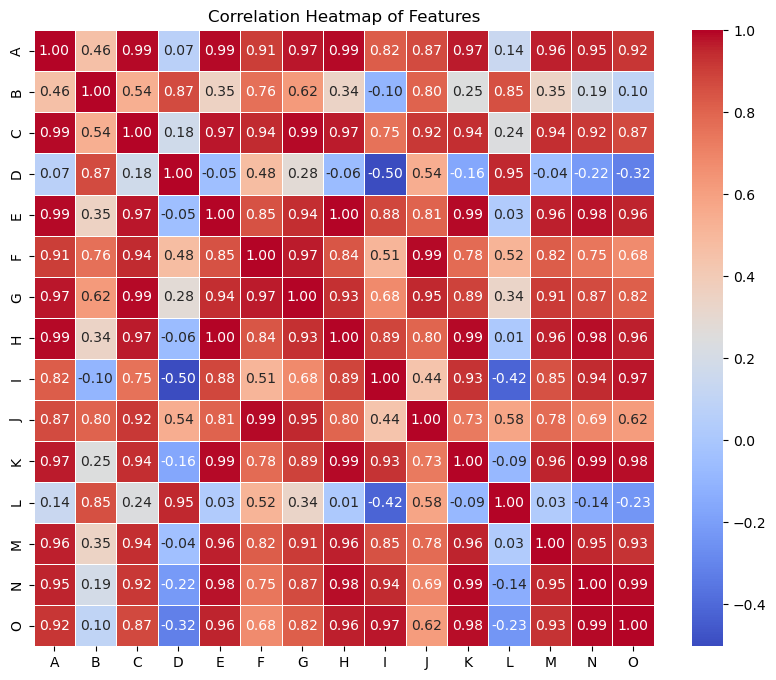

In [9]:
# Calculate the correlation matrix for numerical features
corr_matrix = df.drop(columns=['Class']).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap of Features")
plt.show()

These features are highly correlated, we going to furthur explore collinearity using Variance Inflation Factor (VIF).

In [10]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Dropping the target variable from the features
X = df.drop(columns=['Class'])

# Adding a constant to the model (intercept)
X = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Display the VIF data
print(vif_data)

   Feature         VIF
0    const  242.018854
1        A  462.891934
2        B   10.820621
3        C  275.483416
4        D   94.347911
5        E  308.134901
6        F  123.444047
7        G  106.976975
8        H  308.935455
9        I   82.225009
10       J  122.697691
11       K  180.366534
12       L   10.955633
13       M   14.933252
14       N  123.392019
15       O  200.922139


### Observation:
1. There is presence of multicolliarity present in the data.

2. Some of the features are highly corelated.

## Outlier detection:

I developed a custom script to identify outliers in a feature, specifically by class, because traditional outlier detection methods may not always provide reliable results. 

These methods often flag extreme values as outliers, but such values could actually be regular data points for specific classes. 

By considering the class-based distribution of the feature, my script ensures that we correctly identify true outliers that deviate significantly from the typical values within each class, rather than misclassifying legitimate variations as anomalies.

In [11]:
# Assuming 'df' is the DataFrame and 'Class' is the column containing class labels
classes = df['Class']
features = df.drop('Class', axis=1)

# Function to calculate IQR and bounds for each feature, separately by class
def calculate_iqr_for_class(class_data):
    Q1 = class_data.quantile(0.25)
    Q3 = class_data.quantile(0.75)
    IQR = Q3 - Q1
    upper_bounds = Q3 + 1.5 * IQR
    lower_bounds = Q1 - 1.5 * IQR
    return lower_bounds, upper_bounds

# Function to calculate outliers for each class and feature
def count_outliers_by_class(class_label, feature_name, lower_bounds, upper_bounds):
    class_data = df[df['Class'] == class_label][feature_name]
    outliers = (class_data > upper_bounds[feature_name]) | (class_data < lower_bounds[feature_name])
    return outliers.sum()

# Function to calculate rows with at least one outlier for each class
def count_rows_with_at_least_one_outlier(class_label, lower_bounds, upper_bounds):
    class_data = df[df['Class'] == class_label][features.columns]
    outliers = (class_data > upper_bounds) | (class_data < lower_bounds)
    rows_with_outliers = outliers.any(axis=1).sum()  # Count rows with at least one outlier
    return rows_with_outliers

# Function to identify outliers for each feature based on class-specific bounds
def identify_outliers_by_class(class_label, lower_bounds, upper_bounds):
    class_data = df[df['Class'] == class_label][features.columns]
    outliers = (class_data > upper_bounds) | (class_data < lower_bounds)
    return outliers

# Function to calculate rows with at least one outlier across the entire dataset
def count_total_rows_with_at_least_one_outlier():
    # Initialize a DataFrame to track outliers across all classes
    outlier_mask = pd.DataFrame(False, index=df.index, columns=features.columns)
    
    # Iterate over each class and check for outliers
    for class_label in df['Class'].unique():
        lower_bounds, upper_bounds = calculate_iqr_for_class(df[df['Class'] == class_label][features.columns])
        outliers = identify_outliers_by_class(class_label, lower_bounds, upper_bounds)
        outlier_mask = outlier_mask | outliers  # Combine outliers across all classes
    
    # Count rows with at least one outlier (True) in any feature
    rows_with_outliers = outlier_mask.any(axis=1).sum()
    return rows_with_outliers

# Dictionary to store the result
outliers_by_class_feature = {}
rows_with_at_least_one_outlier = {}
total_outliers_per_class = {}

# Iterate through each class and feature to calculate outliers and rows with outliers
for class_label in df['Class'].unique():
    # Calculate IQR bounds for the current class
    lower_bounds, upper_bounds = calculate_iqr_for_class(df[df['Class'] == class_label][features.columns])

    # Initialize the dictionary for current class outliers
    outliers_by_class_feature[class_label] = {}

    # Calculate outliers by feature for the current class
    for feature_name in features.columns:
        count = count_outliers_by_class(class_label, feature_name, lower_bounds, upper_bounds)
        outliers_by_class_feature[class_label][feature_name] = count
    
    # Count rows with at least one outlier for the current class
    rows_with_at_least_one_outlier[class_label] = count_rows_with_at_least_one_outlier(class_label, lower_bounds, upper_bounds)
    
    # Calculate total number of outliers for the current class
    total_outliers = sum(outliers_by_class_feature[class_label].values())
    total_outliers_per_class[class_label] = total_outliers

# Convert the result to DataFrame for readability
outliers_df = pd.DataFrame(outliers_by_class_feature).T
rows_with_outliers_df = pd.DataFrame.from_dict(rows_with_at_least_one_outlier, orient='index', columns=['Rows with At Least One Outlier'])
total_outliers_df = pd.DataFrame.from_dict(total_outliers_per_class, orient='index', columns=['Total Outliers'])

# Merge all results into a single DataFrame
final_df = outliers_df.join([rows_with_outliers_df, total_outliers_df])

# Reorder the classes and transpose the DataFrame
final_df = final_df.sort_index().T

# Print the final result for outliers by class and feature
print("Outliers by Class and Feature:")
print(final_df)

# Calculate and print the total number of rows with at least one outlier across the entire dataset
total_rows_with_outliers = count_total_rows_with_at_least_one_outlier()
print(f"\nTotal rows with at least one outlier across the dataset: {total_rows_with_outliers}")

Outliers by Class and Feature:
                                1      2       3
A                               0   3096       0
B                               0   3308   99636
C                               0   3195       0
D                               0   3198   99570
E                               0   3100       0
F                               0   3103       0
G                               0   3263       0
H                               0   3150       0
I                               0   3052       0
J                               0   3152       0
K                               0   3139       0
L                               0   3192   96609
M                               0   3085       0
N                               0   3227       0
O                               0   3106       0
Rows with At Least One Outlier  0  45089   99706
Total Outliers                  0  47366  295815

Total rows with at least one outlier across the dataset: 144795


### Observation:
We can notice from the the above output that the number rows with at least one outlier present are 144,795.

We have total 1,200,000 rows in our dataset.

So, the percenatge of rows with at least one outlier = (144795/1200000)*100 = 12.06%

It is the significant amount (>2% standard to drop the rows), so we can not just drop the rows with outlier form our dataset in our data processing step. 


1. The class 1 has no outliers
2. The class 2 has outliers present for every feature/column in dataset
3. The class 3 has outliers present only in 'B', 'D', and 'L' columns.

## Key Observations:
1. There are no null values in the data.
2. There are no duplicate rows in the dataset.
3. The features have have high multicollinearity. 
4. There are outliers present in the data.